# Transformer
파라미터는 아래 그림처럼 논문과 동일하게 설정하였다.

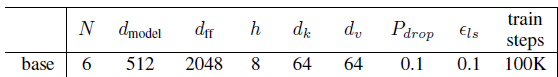

In [ ]:
import torch
from torch import nn

# Positional Encoding

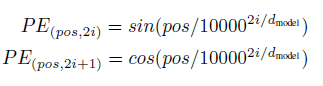

In [ ]:
class PositionalEncoding(nn.Module):
   def __init__(self, d_model, max_len, device):
        super(PositionalEncoding, self).__init__()
        # positional encoding은 input embedding과 elementwise더해져야한다.
        # encoding = [단어의 개수 x 단어 별 차원]
        self.encoding = torch.zeros(max_len, d_model, device=device) #설정된 문장의 최대길이 x 512
        self.encoding.requires_grad = False  # we don't need to compute gradient

        pos = torch.arange(0, max_len, device=device)#0부터 max_length까지 1씩 증가하여 쌓임
        pos = pos.float().unsqueeze(dim=1) # pos = [max_length x 1]차원
       #0부터 d_model까지 2 간격으로 순서대로 쌓임
        _2i = torch.arange(0, d_model, step=2, device=device).float()
        # 'i' means index of d_model (e.g. embedding size = 50, 'i' = [0,50])
        # "step=2" means 'i' multiplied with two (same with 2 * i)
        #아래 코드가 PE 코드를 의미하며 PE[단어의 개수 X 단어의 차원]
        #단어 별 FEATURE가 짝수일 때,
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        #단어 별 FEATURE가 홀수일 때,
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))
        # compute positional encoding to consider positional information of words

    def forward(self, x):
        batch_size, seq_len = x.size()
        # [batch_size = 문장의 개수, seq_len = 문장 별 단어의 최대 개수]
        return self.encoding[:seq_len, :]
        # [max_len, 단어의 차원]
        #단어의 특징을 나타내는 차원마다 주파수가 고정된다.
        #단어의 순서에 따라 pos값이 변하면서 다른 값으로 지정된다.
        #즉, 다른 문장의 같은 위치의 특정 차원은 같은 값을 가짐

# Input Embedding

In [ ]:
self.input_embedding = nn.Embedding(src_dim, hidden_dim)
#소스의 차원(사전단어수)->hidden_dim

# MHA

In [1]:
class MHA(nn.Module):
    def __init__(self, hidden_dim, n_heads):
        super().__init__()

        self.hidden_dim = hidden_dim
        self.n_heads = n_heads
        self.head_dim = int(hidden_dim / n_heads) #각 head의 dimension ex)512/8=64

        self.w_q = nn.Linear(hidden_dim, hidden_dim)
        self.w_k = nn.Linear(hidden_dim, hidden_dim)
        self.w_v = nn.Linear(hidden_dim, hidden_dim)
        self.w_o = nn.Linear(hidden_dim, hidden_dim)

        self.scale = torch.sqrt(torch.tensor(self.head_dim)).to(DEVICE)

def forward(self, Q, K, V, mask = None):

        batch_size = Q.shape[0] #문장의 개수

        Q = self.w_q(Q) # 문장의 개수 x 단어의 개수 x 512
        K = self.w_k(K)
        V = self.w_v(V)
        #512차원으로 (Q,K,V)를 구한 후,8개의 head(64차원씩의 (Q,K,V))로 나눔
        #[문장 x 단어 x헤드 x64]
        # 그리고 QK^T연산을 위해서 헤드와 단어의 순서를 바꿈 by transpose(1,2)
        #즉, [문장 x 헤드 x 단어 x 64]
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        #QK^T연산+정규화
        attention_score = Q@K.permute(0,1,3,2)/self.scale # 문장 x 헤드 x 단어 x 단어

        #mask는 뒤에서 다루겠지만, mask를 해주어야하면
        #그 값을 터무늬없이 작은 값으로 대체하여 softmax를 지나고 나면 고려 안함.
        if mask is not None:
            attention_score[mask] = -1e10 # mask.shape = 문장 x 헤드 x 단어 x 단어

        # attention score의 가로축에 대해서 softmax
        attention_dist = torch.softmax(attention_score, dim=-1)


        attention = attention_dist @ V # 계산된 값[문헤단단]을 v벡터[문헤단64]와 곱함.
                                       # attention.shape=[문장 x 헤드 x 단어 x 헤드 별 차원]

        x = attention.transpose(1,2).contiguous() # [문장 x 단어 x헤드 x헤드별 차원(64)]
        x = x.view(batch_size, -1, self.hidden_dim) # [문장 x 단어 x 차원(512)]
        #위까지가 scaled dot-product attention!
        x = self.fc_o(x) # [문장 x 단어 x 차원(512)]
        return x, attention_dist

NameError: name 'nn' is not defined

# FFN

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, hidden_dim, ff_dim, drop_p):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(hidden_dim, ff_dim),
                                    nn.ReLU(),
                                    nn.Dropout(drop_p),
                                    nn.Linear(ff_dim, hidden_dim))

    def forward(self, x):
        x = self.linear(x)
        return x



> Layer Norm







In [ ]:
class LN(nn.Module):
    def __init__(self, hid_dim):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(hid_dim))
        self.beta = nn.Parameter(torch.zeros(hid_dim))
        self.eps = 1e-12

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, unbiased=False, keepdim=True)

        out = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * out + self.beta
        return out

# Encoder Layer

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, ff_dim, drop_p):
        super().__init__()

        self.self_atten = MHA(hidden_dim, n_heads) #8개의 head별 attention을 구하고 add
        self.self_atten_LN = LN(hidden_dim) # layer별로 norm

        self.FF = FFN(hidden_dim, ff_dim, drop_p) #feed-forward를 거친 후
        self.FF_LN = LN(hidden_dim) # layer별로 norm

        self.dropout = nn.Dropout(drop_p)

    def forward(self, x, enc_mask):

        residual, atten_enc = self.self_atten(x, x, x, enc_mask)
        residual = self.dropout(residual)
        x = self.self_atten_LN(x + residual) #residual은 attention을 거친 결과이고, x는 원래 값
                                             #두 값이 더해져서 LN을 거친다.
        residual = self.FF(x)
        residual = self.dropout(residual)
        x = self.FF_LN(x + residual) # FF를 거치기 전 원본 X와 FF를 거친 residual이 더해져서
                                     # LN을 거친다.
        return x, atten_enc #atten_enc는 각 layer마다의 attention score를 보여줌.
                            #이는 layer가 쌓일수록 attention의 양상을 확인하기 위해 넣음.

# Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, dic_dim, vocab_len, hid_dim, n_heads, n_layers, ff_dim, drop_p):
        super().__init__()
        #embedding은 input의 차원이 [문장 x 단어 x 1]로 단어별 index로 주어지거나
        #아래의 경우는 one-hot encoding으로 주어져서([문장 x 단어 x 사전의 단어수])
        #최종적인 결과는 [문장 x 단어 x hid_dim]이 됨.
        self.input_embedding = nn.Embedding(dic_dim, hid_dim)
        self.pos_embedding = nn.Embedding(vocab_len, hid_dim)

        self.layers = nn.ModuleList([EncoderLayer(hidden_dim, n_heads, ff_dim, drop_p) for _ in range(n_layers)])
        #nn.Sequential은 하나밖에 입력을 못받으니까 ModuleList로 변경
        self.dropout = nn.Dropout(drop_p)

        self.scale = torch.sqrt(torch.tensor(hid_dim)).to(DEVICE)

    def forward(self, src, mask):
         # src.shape = [문장 x 단어], mask.shape = [문장 x 헤드 x 단어 x 단어]

        pos = torch.arange(src.shape[1]).repeat(src.shape[0], 1).to(DEVICE)
        # pos.shape= [문장 x단어], (단어의 개수만큼 index쓰고, 문장수만큼 반복)

        x = self.scale*self.input_embedding(src) + self.pos_embedding(pos)
        #x.shape=[문장 x 단어 x 차원(512)] , input embedding과 positional encoding이 합쳐짐.
        # self.scale 을 곱해주면 position 보다 의미정보를 더 보게 된다
        #(gradient에 self.scale 만큼이 더 곱해짐)
        x = self.dropout(x)

        atten_encs = torch.tensor([]).to(DEVICE)
        for layer in self.layers:
            x, atten_enc = layer(x, mask)
            atten_encs = torch.stack([atten_encs , atten_enc], dim=0)
            # [encoder layer x 문장 x 헤드 x 단어 단어]

        return x, atten_encs

# Masked MHA

In [ ]:
if mask is not None:
            attention_score[mask] = -1e10 # mask.shape = 개헤단단

 class Transformer(nn.Module):
    def __init__(self, src_dim, trg_dim, max_len, hidden_dim, n_heads, n_layers, ff_dim, drop_p):
        super().__init__()

        self.src_pad_idx = SRC.vocab.stoi['<pad>'] #입력문장의 <pad> 토큰의 인덱스
        self.trg_pad_idx = TRG.vocab.stoi['<pad>'] #출력문장의 <pad> 토큰의 인덱스

    def make_enc_mask(self, src): # src.shape = [문장 x 단어]

        #<pad> 토큰에 attention하면 의미가 없지 않아? 그래서 삭제시키고 싶음.
        enc_mask = (src == self.src_pad_idx).unsqueeze(1).unsqueeze(2) # [문장 x 1 x 1 x 단어]
        enc_mask = enc_mask.repeat(1, self.n_heads, src.shape[1], 1) # [문장 x 헤드 x 단어 x 단어]
        # repeat은 뒤를 맞춘 후 element-wise multiply를 하면 차원이 나옴.

        return enc_mask

    def make_dec_mask(self, trg): # trg.shape = [문장 x 단어]

        #일단 pad 토큰 True 변환

        #<pad> 토큰에 attention하면 의미가 없지 않아? 그래서 삭제시키고 싶음.
        dec_pad_mask = (src == self.trg_pad_idx).unsqueeze(1).unsqueeze(2) # [문장 x 1 x 1 x 단어]
        dec_pad_mask = enc_mask.repeat(1, self.n_heads, trg.shape[1], 1) # [문장 x 헤드 x 단어 x 단어]
        # repeat은 뒤를 맞춘 후 element-wise multiply를 하면 차원이 나옴.

        # 뒷 단어를 보지 못하도록 mask를 하기 위해서 아래와 같은 mask 행렬을 만듦(by torch.tril)
        """ decoder mask
        F T T T T
        F F T T T
        F F F T T
        F F F F T
        F F F F F
        """
        trg_dec_mask = torch.tril(torch.ones(trg.shape[0], self.n_heads, trg.shape[1], trg.shape[1]))==0
        # [문장 x 헤드 x 단어 x 단어]
        trg_dec_mask = trg_dec_mask.to(DEVICE)

        #하나라도 mask가 True면 mask (OR)
        dec_mask = trg_pad_mask | trg_dec_mask

        return dec_mask

    def make_enc_dec_mask(self, src, trg):

        #KEY에 대해 MASK를 하는 것이므로 <pad>만 마스크해준다.

        enc_dec_mask = (src == self.src_pad_idx).unsqueeze(1).unsqueeze(2) # [문장 x 1 x 1 x 단어]
        enc_dec_mask = enc_dec_mask.repeat(1, self.n_heads, trg.shape[1], 1) # [문장 x 헤드 x 단어 x 단어]

        return enc_dec_mask

# Decoder Layer

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_dim, n_heads, ff_dim, drop_p):
        super().__init__()

        # masked MHA
        self.self_atten = MHA(hidden_dim, n_heads) #multihead attn을 진행+ add
        self.self_atten_LN = nn.LN(hidden_dim)  #layer norm

        # enc-dec MHA
        self.enc_dec_atten = MHA(hidden_dim, n_heads) #multihead attn을 진행+ add
        self.enc_dec_atten_LN = nn.LN(hidden_dim)  #layer norm

        self.FF = FFN(hidden_dim, ff_dim, drop_p)  #다음단어 예측 확률 반환을 위한 ff
        self.FF_LN = nn.LayerNorm(hidden_dim)   #layer norm

        self.dropout = nn.Dropout(drop_p)

    def forward(self, x, enc_out, dec_mask, enc_dec_mask):

        residual, atten_dec = self.self_atten(x, x, x, dec_mask)
        residual = self.dropout(residual)#dropout을 시킨 것이 residual
        x = self.self_atten_LN(x + residual) #원래 입력 x + x와의 잔차 residual

        residual, atten_enc_dec = self.enc_dec_atten(x, enc_out, enc_out, enc_dec_mask)
        # Q는 디코더로부터 K,V는 인코더로부터!!
        residual = self.dropout(residual)
        x = self.enc_dec_atten_LN(x + residual)

        residual = self.FF(x)
        residual = self.dropout(residual)
        x = self.FF_LN(x + residual)

        return x, atten_dec, atten_enc_dec #층마다 attention score를 보기 위함.



# Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, trg_dim, max_len, hidden_dim, n_heads, n_layers, ff_dim, drop_p):
        super().__init__()

        self.tok_embedding = nn.Embedding(trg_dim, hidden_dim)
        self.pos_embedding = nn.Embedding(max_len, hidden_dim)

        self.layers = nn.ModuleList([DecoderLayer(hidden_dim, n_heads, ff_dim, drop_p) for _ in range(n_layers)])
        self.fc_out = nn.Linear(hidden_dim, trg_dim)

        self.dropout = nn.Dropout(drop_p)

        self.scale = torch.sqrt(torch.tensor(hidden_dim)).to(DEVICE)

    def forward(self, trg, enc_out, dec_mask, enc_dec_mask): # trg.shape = 개단, enc_out.shape = 개단채, dec_mask.shape = 개헤단단

        pos = torch.arange(trg.shape[1]).repeat(trg.shape[0], 1).to(DEVICE) # 개단

        x = self.scale*self.tok_embedding(trg) + self.pos_embedding(pos) # [문장 x 단어 x 차원(512)]
        # self.scale 을 곱해주면 position 보다 token 정보를 더 보게 된다 (gradient에 self.scale 만큼이 더 곱해짐)
        x = self.dropout(x)

        atten_decs = torch.tensor([]).to(DEVICE)
        atten_enc_decs = torch.tensor([]).to(DEVICE)
        for layer in self.layers:
            x, atten_dec, atten_enc_dec = layer(x, enc_out, dec_mask, enc_dec_mask)
            atten_decs = torch.stack([atten_decs , atten_dec], dim=0)
            # [dec_layer x 문헤단단 ]
            atten_enc_decs = torch.stack([atten_enc_decs , atten_enc_dec], dim=0)
            # [end_dec layer x 문헤단단]

        x = self.fc_out(x)

        return x, atten_decs, atten_enc_decs